<header>
   <p  style='font-size:36px;font-family:Arial; color:#F0F0F0; background- padding-left: 20pt; padding-top: 20pt;padding-bottom: 10pt; padding-right: 20pt;'>
       Cash Demand Forecasting using Clearscape Analytics
  <br>
       <img id="teradata-logo" src="https://storage.googleapis.com/clearscape_analytics_demo_data/DEMO_Logo/teradata.svg" alt="Teradata" style="width: 125px; height: auto; margin-top: 20pt;">
    </p>
</header>

<p style = 'font-size:20px;font-family:Arial'><b>Introduction</b></p>
<p style = 'font-size:16px;font-family:Arial'>    
Predicting future demand for cash in Automatic Teller Machines (ATMs) is crucial for any bank as ATMs are still largely used to dispense cash to customers. ATM cash replenishment is the process of refilling an ATM machine with a specific amount of cash. Due to vacillating users’ demands and seasonal patterns, it is a very challenging problem for financial institutions to keep the optimal amount of cash for each ATM.  <br><br> In this demo, we present a time series model of Teradata Auto Regressive Integrated Moving Average (ARIMA) to solve this problem, perform different exploratory analysis tests, visualizations, diagnostic statistics and more using the In_Db capability of Teradata Vantage.<br>    
We will forecast the amount of required future cash in an ATM by developing a time-series modelling pipeline on cash demand data .The demo shows the power of Vantage through its in-Db analytics time-series capabilities which provide a comprehensive suite of functions most commonly used by Data Scientists across the industry including but not limited to; 
<ul style = 'font-size:16px;font-family:Arial'>
    <li><b>Data preparation</b>: Resampling, converting irregular to regular</li>
    <li><b>Data exploration</b>: Detect stationarity and periodicity</li>
    <li><b>Eliminate Non-stationarity</b>: Seasonal normalizing</li>
    <li><b>Formulate candidate models</b>: ARIMA</li>
    <li><b>Goodness of Fit</b>: Parameter estimates, hypothesis statistical tests</li>
    <li><b>Model Validation</b>: Arima Validate</li>
    <li><b>Model Forecasting</b>: Unnormalize, and forecast on test data</li>
    
The implemented function are from the following documentations;
       
- [Teradata Vantage™ - Analytics Database Analytic Functions](https://docs.teradata.com/search/all?query=+Analytics+Database+Analytic+Functions&content-lang=en-US)
- [UAF Time-Series](https://docs.teradata.com/search/all?query=Unbounded+Array+Framework+(UAF)&filters=category~%2522User+Guide%2522&content-lang=en-US)    
    
<p style = 'font-size:20px;font-family:Arial'><b>Unbounded Array Framework (UAF)</b></p>
    
(UAF) is the Teradata framework for building end-to-end time series forecasting pipelines. It takes the following as inputs.<br>
    
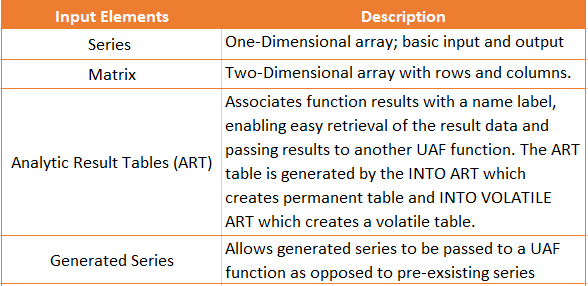


<br> For further information, please [refer here](https://docs.teradata.com/search/all?query=Unbounded+Array+Framework+(UAF)&content-lang=en-US)
    
<p style = 'font-size:20px;font-family:Arial'><b>Cash Demand Forecasting Demo Data</b></p> 
<b>ATM Dataset</b> : For this notebook we have used anonymised dataset for an ATM from a bank in the UK. The data is composed of daily cash demands for the ATM along with date.

<hr style="height:2px;border:none;">

<p style = 'font-size:20px;font-family:Arial'><b>1. Connect to Vantage</b></p>

In [ ]:
%connect local, hidewarnings=true

In [ ]:
Set query_band='DEMO=Cash_Demand_Forecasting_SQL.ipynb;' update for session;

<p style = 'font-size:16px;font-family:Arial'>You will be prompted to provide the password. Enter your password, press the Enter key, then <b>use down arrow</b> to go to next cell.</p>

<p style = 'font-size:18px;font-family:Arial'><b>Getting Data for This Demo</b></p>
<p style = 'font-size:16px;font-family:Arial'>    
We have provided data for this demo on cloud storage. You have the option of either running the demo using foreign tables to access the data without using any storage on your environment or downloading the data to local storage which may yield somewhat faster execution, but there could be considerations of available storage. There are two statements in the following cell, and one is commented out. You may switch which mode you choose by changing the comment string.

In [ ]:
---call get_data('DEMO_UAF_cloud');    -- takes about 20 seconds, estimated space: 0 MB
call get_data('DEMO_UAF_local');     -- takes about 40 seconds, estimated space: 1MB

<p style = 'font-size:16px;font-family:Arial'>Next is an optional step – if you want to see status of databases/tables created and space used.</p>

In [ ]:
call space_report();  -- optional, takes about 10 seconds

<p style = 'font-size:16px;font-family:Arial'>Printing some sample rows from the dataset</p> 

In [ ]:
SELECT TOP 5 * FROM DEMO_UAF.atm_data;

<p style = 'font-size:16px;font-family:Arial'> As we can see from the sample data above there is a date column and demand for ATM's for that day. Let us take one ATM's data and do our analysis on it. 

In [ ]:
Select count(*) from DEMO_UAF.atm_data;

<p style = 'font-size:16px;font-family:Arial'> We will use these 735 records for further analysis.

<hr style="height:2px;border:none;">

<p style = 'font-size:20px;font-family:Arial'><b>2. Data Cleaning</b></p>

<p style = 'font-size:20px;font-family:Arial'><b>TD_GetRowsWithMissingValues</b></p>
<p style = 'font-size:16px;font-family:Arial'>
    <b>TD_GetRowsWithMissingValues</b> displays the rows that have NULL values in the specified input table columns. Please refer <a href ='https://docs.teradata.com/search/all?query=TD_GetRowsWithMissingValues&sort=last_update&content-lang=en-US'>here </a> for more information.
<br>
<p style = 'font-size:16px;font-family:Arial'><b>Usage</b><br> We have used this function to print if there are any missing rows for our selected target column which is NN5_3. This function would help us identify what is the pattern of missing data (if it exists) and on which time-stamp the data is missing. After this, we can plan accordingly on how to deal with these missing values.</p>

In [ ]:
SELECT DateTime,Amt FROM TD_GetRowsWithMissingValues ( 
    ON DEMO_UAF.atm_data
    AS InputTable
    USING
    TargetColumns ('Amt')
) AS dt;

<p style = 'font-size:16px;font-family:Arial'>We can confirm the null counts from below.

In [ ]:
select count(*) from DEMO_UAF.ATM_Data where Amt is NULL;

<p style = 'font-size:20px;font-family:Arial'><b>TD_OutlierFilterFit</b></p>
<p style = 'font-size:16px;font-family:Arial'>
    <b>Outlier</b>: It’s a data point that is significantly different from other data points in a data set.<br>While this definition might seem straightforward, determining what is or isn’t an outlier is actually pretty subjective, depending on the study and the breadth of information being collected.<br>
    <b>TD_OutlierFilterFit</b> function identifies the values of the upper, and lower bounds and the median value in each column. It is useful because it will help the user to identify in what range the values for a specific column lies. Then these useful insights are used by another function TD_OutlierFilterTransform to highlight the value(s) which is/are significantly high or low from the computed statistics/average value of the column.<br>
    You can use ReplacementValue as <b>'delete' | 'null' | 'median' | replacement_value</b> either of the parameter value to deal with the outliers.<br>Please refer <a href ='https://docs.teradata.com/search/all?query=OutlierFilterFit&sort=last_update&content-lang=en-US'>here </a> for more information.<br><br>
<p style = 'font-size:16px;font-family:Arial'><b>Usage</b><br> When dealing with time series data we have to identify the outliers and deal with them. When dealing with large datasets we can get the statistics like upper, and lower bounds and the median value in targeted columns in no time using Teradata and its outlierfilterfit function.

In [ ]:
CREATE VOLATILE TABLE outlier_fit AS (
    SELECT * FROM TD_OutlierFilterFit (
    ON DEMO_UAF.atm_data AS InputTable
    USING
    TargetColumns ('Amt')
    LowerPercentile (0.05)
    UpperPercentile (0.95)
    OutlierMethod ('percentile')
    ReplacementValue ('delete')
    PercentileMethod ('PercentileCont')
    ) 
    AS dt) 
WITH DATA
ON COMMIT PRESERVE ROWS;

<p style = 'font-size:16px;font-family:Arial'>Printing the output of the outlier_fit function

In [ ]:
SELECT * FROM  outlier_fit;

<p style = 'font-size:20px;font-family:Arial'><b>TD_OutlierFilterTransform</b></p>
<p style = 'font-size:16px;font-family:Arial'>
    <b>TD_OutlierFilterTransform</b> Filters outliers from the input table. The metrics for determining outliers comes from TD_OutlierFilterFit output.The TD_OutlierFilterTransform function uses the statistical values from the TD_OutlierFilterFit function and runs it against each column. This function then identifies the value of the outlier which are way above or below the normal values. Please refer <a href ='https://docs.teradata.com/search/all?query=OutlierFilterTransform&sort=last_update&content-lang=en-US'>here </a> for more information.<br><br>
<p style = 'font-size:16px;font-family:Arial'><b>Usage</b><br> 
 <ul style = 'font-size:16px;font-family:Arial'>
     <li>This function works with the TD_OutlierFilterFit Function.</li>
     <li>In real-world scenarios, there is too much noise in the data, and outliers are expected, so it is important to identify outliers in the data and treat them in any possible way so that they do not impact the overall statistics of the data and the accuracy of the results.</li>
     <li>If your data is at scale and you want to identify the outliers quickly then Teradata can perform this task within its database in a few seconds.</li>

<p style = 'font-size:16px;font-family:Arial'>Applying the TD_OutlierFilterTransform function and building the table for the results.

In [ ]:
CREATE MULTISET VOLATILE TABLE TD_OutlierFilterTransform AS (
    SELECT * FROM TD_OutlierFilterTransform (
    ON DEMO_UAF.atm_data AS InputTable PARTITION BY ANY
    ON outlier_fit AS FitTable DIMENSION) AS dt) 
    WITH DATA
    ON COMMIT PRESERVE ROWS;

<p style = 'font-size:16px;font-family:Arial'>Checking if any null values are present after filtering out the outliers.

In [ ]:
select count(*) from TD_OutlierFilterTransform where amt is NULL;

<p style = 'font-size:16px;font-family:Arial'>The number of rows in the dataset after the outlier removal

In [ ]:
select count(*) from TD_OutlierFilterTransform;

<p style = 'font-size:20px;font-family:Arial'><b>TD_Resample</b></p>
<p style = 'font-size:16px;font-family:Arial'>
    <b>TD_Resample</b> function Transforms converts irregular time series into a regular time series and performs linear interpolation. Once the outliers are removed the time series is converted to irregular series. TD_Resample can also be used to alter the sampling interval for a time series. Please refer <a href ='https://docs.teradata.com/search/all?query=resample&sort=last_update&content-lang=en-US'>here </a> for more information.
<br>
<p style = 'font-size:16px;font-family:Arial'><b>Usage</b><br> 
     <ul style = 'font-size:16px;font-family:Arial'>
     <li>When doing forecasting we make use of past data points to predict future data points. But if the past data is too far in the past, then we will get inaccurate predictions. This is why we need to fill up missing values. We can fill up missing data using interpolation.</li>
         <li>If your dataset is at scale and you want to interpolate the missing values then using Teradata in database capability one can interpolate the targeted column in no time. Teradata has the capability to deal with millions of rows within seconds and perform any function on them.</li>

<p style = 'font-size:16px;font-family:Arial'>Finding the minimum date so that we can resample the data from this date onwards.

In [ ]:
SELECT MINIMUM(DateTime) FROM TD_OutlierFilterTransform;

<p style = 'font-size:16px;font-family:Arial'>Applying the TD_RESAMPLE function and building the table for the results.

In [ ]:
EXECUTE FUNCTION INTO VOLATILE ART(resampled_atm_data)

TD_RESAMPLE(
    SERIES_SPEC( 
         TABLE_NAME(TD_OutlierFilterTransform), 
         ROW_AXIS(timecode(DateTime)),
         SERIES_ID(idcol),
         PAYLOAD(FIELDS(Amt),CONTENT(REAL))
     ),
     FUNC_PARAMS(
         TIMECODE(
              START_VALUE(TIMESTAMP '1996-03-19 00:00:00'), 
              DURATION(DAYS(1))
          ),
          INTERPOLATE(LINEAR)
     )

);

<p style = 'font-size:16px;font-family:Arial'>Selecting top 5 rows from the resampled_atm_data table and ordering the results by date (i.e ROW_I)

In [ ]:
SELECT top 5 * FROM resampled_atm_data order by ROW_I

<hr style="height:2px;border:none;">

<p style = 'font-size:20px;font-family:Arial'><b>3. Data Exploration</b></p>

<p style = 'font-size:20px;font-family:Arial'><b>TD_UnivariateStatistics</b></p>
<p style = 'font-size:16px;font-family:Arial'>
    <b>TD_UnivariateStatistics</b> function Displays descriptive statistics for each specified numeric input table column.<br>Please refer <a href ='https://docs.teradata.com/search/all?query=UnivariateStatistics&sort=last_update&content-lang=en-US'>here </a> for more information.
    <br><b>Stats</b>: Sum, count, maximum, minimum, mean, uncorrected sum of squares, null count, positive values count, negative values count, zero values count, top5, bottom5, range, geometric mean, harmonic mean, variance, standard deviation, standard error, skewness, kurtosis, coefficient, corrected sum of squares, mode, median, unique entity count, interquartile range, trimmed mean, percentiles can be calculated by this function.
    <br>
<p style = 'font-size:16px;font-family:Arial'><b>Usage</b><br> 
    <ul style = 'font-size:16px;font-family:Arial'>
        <li><b>TD_univariateStatistics</b> function is useful If a user wants to know statistical insights from the data.</li>
<li>Users can use the in-database capability of Teradata to get variety of stats (mentioned above) on their data table, by passing column names in the TargetColumns parameter. It is useful to get the general statistics on the data like mean, Variance, Range, minimum and maximum from the data to better understand and process the data. The user can do all this on million of rows and columns with the great performance and speed capability of Teradata.</li>

<p style = 'font-size:16px;font-family:Arial'> Applying the TD_UnivariateStatistics function and building the table for the results

In [ ]:
SELECT * 
FROM TD_UnivariateStatistics (
ON resampled_atm_data AS InputTable
USING 
TargetColumns ('Amt')
Stats( 
          'MEAN',
          'TRIMMED MEAN',
          'MEDIAN',
          'MODE',           
          'SKEWNESS',
          'STANDARD ERROR',
          'STANDARD DEVIATION',
          'KURTOSIS',
          'SUM',
          'RANGE',
          'VARIANCE',
          'INTERQUARTILE RANGE',
          'MINIMUM',
          'MAXIMUM')

) As dt;


<p style = 'font-size:20px;font-family:Arial'><b>TD_InputValidator</b></p>
<p style = 'font-size:16px;font-family:Arial'>
    <b>TD_InputValidator</b>  validates the data and identifies series and matrixes that have indiscrete data. Discrete data is classified as follows:<ul style = 'font-size:16px;font-family:Arial'><b>Series data</b><li>
        Interval is the same for ROW_AXIS field.</li>
<li>No duplicate ROW_AXIS field in same series.</li></ul>
<ul style = 'font-size:16px;font-family:Arial'><b>Matrix data</b><li>Interval is the same for ROW_AXIS field.</li>
    <li>Interval is the same for COLUMN_AXIS field.</li>
    <li>No duplicate ROW_AXIS or no duplicate COLUMN_AXIS in same matrix.</li>
    <li>Number of rows in each series (wavelet) is the same.</li>
    <li>For each series (wavelet), COLUMN_AXIS starts from same value under row major</li></ul>.
    <p style = 'font-size:16px;font-family:Arial'>Please refer <a href ='https://docs.teradata.com/search/all?query=InputValidator&sort=last_update&content-lang=en-US'>here </a> for more information.</p>
    <br>
<p style = 'font-size:16px;font-family:Arial'><b>Usage</b><br> TD_InputValidator function can identify irregular data points in the series. It is crucial to know and deal with those irregular data point for a model to better fit on the data.

<p style = 'font-size:16px;font-family:Arial'>Applying the TD_InputValidator function and building the table for the results

In [ ]:
EXECUTE FUNCTION INTO VOLATILE ART(Results_first)
TD_INPUTVALIDATOR(
    SERIES_SPEC (TABLE_NAME(resampled_atm_data), ROW_AXIS(TIMECODE(ROW_I)),
    SERIES_ID(idcol), PAYLOAD(FIELDS(Amt),CONTENT(REAL))
),
   FUNC_PARAMS(FAILURE_MODE('FUNC_ALL'))
);

<p style = 'font-size:16px;font-family:Arial'>Checking the result table for TD_InputValidator; the table is empty meaning there are no irregular intervals in the selected series.

In [ ]:
SELECT * FROM Results_first;

<hr style="height:2px;border:none;">

<p style = 'font-size:20px;font-family:Arial'><b>4. TD_Plot</b></p>
<p style = 'font-size:16px;font-family:Arial'>
    <b>TD_Plot</b> provides the ability to generate charts. The generated charts can be in the JPG, PNG, or SVG formats. The following chart styles are available in Teradata 17.20:
<ul style = 'font-size:16px;font-family:Arial'>
    <li>Line Plot <span style="color: green;">(used in this demo)</span></li>
    <li>Scatter Plot <span style="color: gray;">(not relevant for this demo)</span></li>
    <li>Bar Plot <span style="color: green;">(used in this demo)</span></li>
    <li>Mesh Plot <span style="color: gray;">(not relevant for this demo)</span></li>
    <li>Seismic Wiggle Plot <span style="color: gray;">(not relevant for this demo)</span></li>
    <li>Geometry Plot <span style="color: gray;">(not relevant for this demo)</span></li>
    </ul>
<p style = 'font-size:16px;font-family:Arial'>Please refer <a href ='https://docs.teradata.com/search/all?query=TD_PLOT&content-lang=en-US'>here</a> and Function Output are <ul style = 'font-size:16px;font-family:Arial'><li>Derived-series identifier: The resultant series identifier inherited from SERIES_ID or MATRIX_ID declaration.</li><li>IMAGE: Plot image in the format specified in the function command.</li> 
    <br>
<p style = 'font-size:16px;font-family:Arial'><b>Business Value</b><br> 
<ul style = 'font-size:16px;font-family:Arial'>
     <li>If you have a large dataset it might get difficult for someone to analyze data that is in the form of a table. So for a better understanding of the data, we can visualize the whole data in the form of plots and graphs. We generally use graphs to see the trends and the relation of one variable over another. It is also referred to as the effect of one variable on another. For example w.r.t our use case, cash demand forecasting if we want to see the cash flow with respect to each month we can use the bar graph, If we want to visualize the trends of cash flow over a year we can use the line plot.</li><li>
TD_Plot gives us the capability when dealing with a large dataset to visualize these kinds of plots within a few seconds without compromising on accuracy and performance.</li>

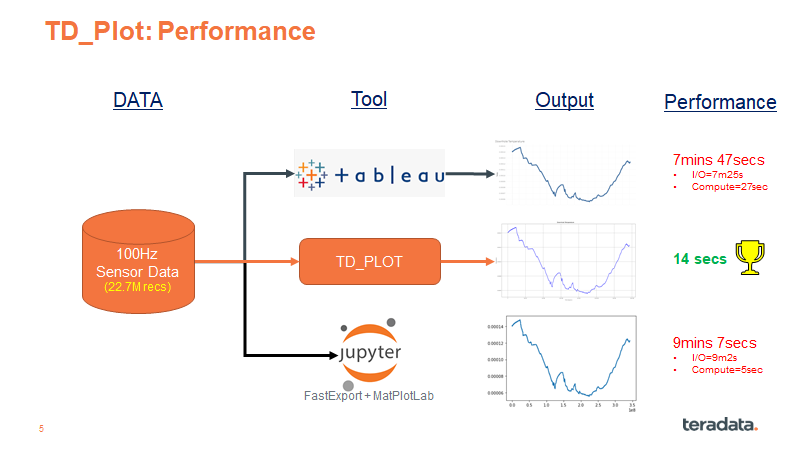

<h3 style = 'font-size:18px;font-family:Arial'><b>Line Plot</b></h3><p style = 'font-size:16px;font-family:Arial'><b>Description</b><br>
A line chart visualizes data as a series of plot points, each connected by a straight line. It is a key decision-making tool for comparing changes across different set periods. Most often line charts are used to show changes over periods of time. The line chart in this demo demonstrates the relation between the time_series and the weekly sales.<ul style = 'font-size:16px;font-family:Arial'><li>On the X-Axis You'll find the timeseries</li><li>On the Y-Axis you'll find the Amt (target column)</li><br><b>Function Significance</b><br><ul style = 'font-size:16px;font-family:Arial'><li>We plotted the line chart to understand the trend between the time series and the weekly sales.</li><li>The other reason is that we can see the general trend of the number of sales over certain time.</li></ul>
    <br>
<p style = 'font-size:16px;font-family:Arial'><b>Usage</b> 
<ul style = 'font-size:16px;font-family:Arial'>You can use line charts to help inform business decisions for a wide range of use cases across departments, including:
    <li>Highlight department spending</li>
    <li>Track stock movement</li>
    <li>Compare historical revenue between products</li><li>Identify customer satisfaction scores</li>

<p style = 'font-size:16px;font-family:Arial'>Applying the TD_Plot function 

<p style = 'font-size:16px;font-family:Arial' ><b><i>* Right click on the image column and select view image. 

In [ ]:
EXECUTE FUNCTION 
TD_Plot
(
    SERIES_SPEC
    (
        TABLE_NAME(resampled_atm_data),
        ROW_AXIS(TIMECODE(ROW_I)),
        SERIES_ID(idcol),
        PAYLOAD
        (
           FIELDS(Amt),
           CONTENT(REAL)
        )
    )where cast(row_i as date) <= '1996-04-18',
    FUNC_PARAMS
    (
        LAYOUT(1,1),
        TITLE('LINE GRAPH'),
        PLOTS[
            (
                ID(1),
                CELL(1,1),
                TITLE ('DATASET TIME SERIES'),
                MARKER('o'),
                LEGEND('best'),
                XLABEL('TIMESERIES'),
                YLABEL('Amt')
            )
        ],
        WIDTH(1200),
        HEIGHT(500)
    )
);

<p style = 'font-size:16px;font-family:Arial'>In the plot above we can see the daily amount of atm for a month. Try changing the where condition to see the plot for a different month or for the whole set of data.

<h3 style = 'font-size:18px;font-family:Arial'><b>Bar Plot</b></h3><p style = 'font-size:16px;font-family:Arial'><b>Description</b><br>
An excellent way to compare objects with the same parameters, a bar chart plots numeric values as bars. The Bar Chart in this demo demonstrates the relation between months and sum of cash flows.<ul style = 'font-size:16px;font-family:Arial'><li>On the Y-Axis you'll find the Sum of cash flows over a month</li><br><b>Function Significance</b><br><ul style = 'font-size:16px;font-family:Arial'><li>(*w.r.t our use case*)It would be good to have if we have this type of visualization in which we can see the cash flow within months over a period. We can identify the month in which the cash flow increase, which months are highlighted for highest and lowest cash flows by analyzing the data from past few years etc.</li></ul>
        <p style = 'font-size:16px;font-family:Arial'><b>Usage</b><br> 
<ul style = 'font-size:16px;font-family:Arial'>We can use bar charts to help inform business decisions for a wide range of use cases across departments:
    <li>Compare revenue between businesses</li>
    <li>Highlight budget variance</li>
    <li>Visualize best to worst performers</li>
    <li>Categorize survey responses</li>
     <li>Track historical sales performance</li>

<p style = 'font-size:16px;font-family:Arial'>Creating a table which will have the monthly sum of cash flows over months for a year. We Do this by extracting month and year from the date column , applying Sum on the cash flows (Amt) and then grouping them on the bases of months and years this would give us the sum of monthly cash flows for years.

In [ ]:
CREATE VOLATILE TABLE monthlyavg_atm_data AS ( 
    SELECT 
    EXTRACT (MONTH FROM ROW_I) as "Month_",
    EXTRACT (YEAR FROM ROW_I) as "YEAR_",
    SUM(Amt) as Amt
    FROM resampled_atm_data
    GROUP BY Month_,YEAR_) 
WITH DATA
on commit preserve rows;

<p style = 'font-size:16px;font-family:Arial'>Printing the rows from the table and ordering them by month and year

In [ ]:
SELECT * FROM monthlyavg_atm_data ORDER BY YEAR_,MONTH_;

<p style = 'font-size:16px;font-family:Arial'>Applying the TD_Plot function 
<p style = 'font-size:16px;font-family:Arial' > <b><i>* Right click on the image column and select view image. 

In [ ]:
EXECUTE FUNCTION 
TD_Plot
(
    SERIES_SPEC
    (
        TABLE_NAME(monthlyavg_atm_data),
        ROW_AXIS(SEQUENCE(MONTH_)),
        SERIES_ID(YEAR_),
        PAYLOAD
        (
           FIELDS(Amt),
           CONTENT(REAL)
        )
    )WHERE YEAR_=1996,
    FUNC_PARAMS
    (
        LAYOUT(1,1),
        TITLE('BAR GRAPH'),
        PLOTS[
            (
                ID(1),
                CELL(1,1),
                TITLE ('DATASET TIME SERIES'),
                TYPE('bar'),
                LEGEND('best'),
                XLABEL('MONTH'),
                YLABEL('Amt')
            )
        ],
        WIDTH(1200),
        HEIGHT(500)
    )
);

<p style = 'font-size:16px;font-family:Arial'>In the plot above we can see the monthly average cash flow for the year 1996. Notice that the graph starts from March because we have data in the dataset starting from March, 1996.

<h3 style = 'font-size:18px;font-family:Arial'><b>Seasonal plot of month over year</b></h3><p style = 'font-size:16px;font-family:Arial'><b>Description</b><br>
The seasonal plot of month over year actually is a line graph It is plotted to visualize the trend of cash flow over month and uniquely identifying the trend for each year. It is build to see if the trend repeats each year or not.

<p style = 'font-size:16px;font-family:Arial'>Applying the TD_Plot function 
<p style = 'font-size:16px;font-family:Arial' > <b><i>* Right click on the image column and select view image. 

In [ ]:
EXECUTE FUNCTION 
TD_Plot
(
    SERIES_SPEC
    (
        TABLE_NAME(monthlyavg_atm_data),
        ROW_AXIS(SEQUENCE(MONTH_)),
        SERIES_ID(YEAR_),
        PAYLOAD
        (
           FIELDS(Amt),
           CONTENT(REAL)
        )
    ),
    FUNC_PARAMS
    (
        LAYOUT(1,1),
        TITLE('SEASONAL PLOT OF MONTH OVER YEAR'),
        PLOTS[
            (
                ID(1),
                CELL(1,1),
                TITLE ('DATASET TIME SERIES'),
                MARKER('o'),
                LEGEND('best'),
                XLABEL('TIMESERIES'),
                YLABEL('Amt')
            )
        ],
        WIDTH(900),
        HEIGHT(500)
    )
);

<p style = 'font-size:16px;font-family:Arial'>From the monthly graph above above we can see that there is slight upward trend in cash flow in 1996 and 1997 but they dont follow the same pattern.

<p style = 'font-size:20px;font-family:Arial'><b>TD_PowerSpec</b></p>
<p style = 'font-size:16px;font-family:Arial'>
    <b>TD_PowerSpec</b> Converts a series from the time or spatial domain to the frequency domain in order to facilitate frequency domain analysis. Its calculations serve to estimate the correct power spectrum associated with the series.<br>Please refer <a href ='https://docs.teradata.com/search/all?query=TD_POWERSPEC&content-lang=en-US'>here </a> and Function Output are <ul style = 'font-size:16px;font-family:Arial'><li>Derived-series-identifier: The resultant series identifier inherited from the SERIES_ID.</li><li>ROW_I: The index of time series.</li><li>SPECTRAL_DENSITY_field: The calculated magnitude.</li></ul>
<p style = 'font-size:16px;font-family:Arial'><b>Usage</b><br> 
<ul style = 'font-size:16px;font-family:Arial'>
    <li>TD_PoweSpec helps us to visualize the data in the frequency domain.</li><li>We can identify different patterns in the series, and all this processing is done in IN_DB so Teradata is Maintaining the processing time to a minimum.</li>

<p style = 'font-size:16px;font-family:Arial'>Applying the TD_PowerSpec function and building the table for the results

In [ ]:
EXECUTE FUNCTION INTO VOLATILE ART(PWRSPEC_RES_tw) 

TD_POWERSPEC( 
    SERIES_SPEC(
    TABLE_NAME(resampled_atm_data), 
    SERIES_ID(idcol),
    ROW_AXIS(TIMECODE(ROW_I)),
    PAYLOAD(FIELDS(Amt), CONTENT(REAL))),
    FUNC_PARAMS( FREQ_STYLE("K_RADIANS") ));

<p style = 'font-size:16px;font-family:Arial'>Printing top 5 rows of the table

In [ ]:
select top 5 * from PWRSPEC_RES_tw;

<p style = 'font-size:16px;font-family:Arial' >Let us plot the power spectrum.
<p style = 'font-size:16px;font-family:Arial' > <b><i>* Right click on the image column and select view image. 

In [ ]:
EXECUTE FUNCTION 
TD_Plot
(
    
    SERIES_SPEC
    (
        TABLE_NAME(PWRSPEC_RES_tw),
        ROW_AXIS(SEQUENCE(ROW_I)),
        SERIES_ID(idcol),
        PAYLOAD
        (
           FIELDS(SPECTRAL_DENSITY_Amt),
           CONTENT(REAL)
        )
    ),
   FUNC_PARAMS
    (
        LAYOUT(1,1),
        TITLE('POWER SPECTRUM RESULTS'),
        PLOTS[
            (
                ID(1),
                CELL(1,1),
                TITLE ('DATASET TIME SERIES'),
                MARKER('o'),
                LEGEND('best'),
                XLABEL('X ROW_I in W K_RADIANS'),
                YLABEL('Y SPECTRAL DENSITY MAGNITUDE')
                ,GRID(FORMAT('-'))
            )
        ],
        WIDTH(900),
        HEIGHT(500)
    )
        
);

<p style = 'font-size:16px;font-family:Arial'>The power spectrum plot provides information about the intensity or magnitude of each frequency component present in the signal. The power spectrum indicates how the power or energy of the signal is distributed across different frequencies. From the above power spectrum plot we can see that there is only one significant frequency and not many other frequencies hence we can conclude that there is not much noise in the data.

<p style = 'font-size:20px;font-family:Arial'><b>TD_ACF</b></p>
<p style = 'font-size:16px;font-family:Arial'>
    <b>TD_ACF</b> Calculates the autocorrelation or autocovariance of a time series. Autocorrelation and autocovariance show how the time series correlates or covaries with itself when delayed by a lag in time or space. When TD_ACF is computed, a coefficient corresponding to a particular lag is affected by all the previous lags.<br> Please refer <a href ='https://docs.teradata.com/search/all?query=TD_ACF&content-lang=en-US'>here </a> for more information.<br> 
<p style = 'font-size:16px;font-family:Arial'><b>Function Significance</b> 
<ul style = 'font-size:16px;font-family:Arial'>
    <li>Autocorrelation represents the degree of similarity between a given time series and a lagged version of itself over successive time intervals.</li>
    <li>Autocorrelation measures the relationship between a variable's current value and its past values.</li>
    <li>An autocorrelation of +1 represents a perfect positive correlation, while an autocorrelation of negative 1 represents a perfect negative correlation.</li>
    <li>Technical analysts can use autocorrelation to measure how past influence affects security prices.</li>
     <li>If You want to visualize how much previous values are impacting your current value or how much dependent the current value is on the previous values then you have to use this function.</li></ul>
     <p style = 'font-size:16px;font-family:Arial'><b>Business Value</b> 
     <ul style = 'font-size:16px;font-family:Arial'>
    <li>This exploratory analysis is useful for identifying how many previous values are impacting the current value in this data of cash flows<ul><li>Sales</li><li>Expenditures vs Revenue</li></ul></li>
    <li>Teradata can help us find autocorrelations for years with high performance, efficiency, and speed as compared to others. It can process millions of rows and find the autocorrelation for you within seconds.</li></ul>

<p style = 'font-size:16px;font-family:Arial'>Applying the TD_ACF function and building the table for the results

In [ ]:
EXECUTE FUNCTION COLUMNS(OUT_Amt AS Amt) INTO VOLATILE ART(ACF_RES_tw)
        
TD_ACF ( 
    SERIES_SPEC(
    TABLE_NAME(resampled_atm_data),
    SERIES_ID(idcol), 
    ROW_AXIS(TIMECODE(ROW_I)),                             
    PAYLOAD (FIELDS(Amt), CONTENT(REAL))),
    FUNC_PARAMS(MAXLAGS(14), FUNC_TYPE(0), QSTAT(1), DEMEAN(1), ALPHA(0.05) ));


<p style = 'font-size:16px;font-family:Arial'>Viewing the top 5 rows of the table.

In [ ]:
select top 5 * from ACF_RES_tw;

<p style = 'font-size:16px;font-family:Arial'>Applying the TD_Plot function for plotting.
<p style = 'font-size:16px;font-family:Arial' > <b><i>* Right click on the image column and select view image. 

In [ ]:
EXECUTE FUNCTION 
TD_Plot
(
   SERIES_SPEC
    (
        TABLE_NAME(ACF_RES_tw),
        ROW_AXIS(SEQUENCE(ROW_I)),
        SERIES_ID(idcol),
        PAYLOAD (FIELDS(Amt, CONF_OFF_Amt),CONTENT(MULTIVAR_REAL) )
    ),

   FUNC_PARAMS
    (
        LAYOUT(1,1),
        TITLE('ACF RESULT SERIES'),
        PLOTS[
            (
                ID(1),
                CELL(1,1),
               TYPE('corr')
               ,XLABEL('X LAG')
               ,YLABEL('Y Magnitude')
            )
        ],
        WIDTH(900),
        HEIGHT(500)
    )
            
);

<p style = 'font-size:16px;font-family:Arial'>The ACF measures the correlation between a time series and its lagged values. It helps determine the value of q, which represents the order of the moving average (MA) component in an ARIMA model. If the ACF decays exponentially or gradually decreases and crosses the confidence interval (shaded region), it suggests an AR model. If the ACF cuts off abruptly after a certain lag, it indicates an MA model. From the above ACF plot we can take the lag of 1 and the q value as 2 for our baseline model.

<p style = 'font-size:20px;font-family:Arial'><b>TD_PACF</b></p>
<p style = 'font-size:16px;font-family:Arial'>
    <b>TD_PACF</b> provides insight as to whether the function being modeled is stationary or not. The partial auto correlations are used to measure the degree of correlation between time series sample points. The algorithm removes the effects of the previous lag.<br> Please refer <a href ='https://docs.teradata.com/search/all?query=TD_PACF&content-lang=en-US'>here </a> for more information.
    <p style = 'font-size:16px;font-family:Arial'><b>Function Significance</b> 
<ul style = 'font-size:16px;font-family:Arial'>
    <li>The partial autocorrelation function, is used to find the association between two timestamps that the shorter lags between those observations do not explain.</li>
    </ul>
     <p style = 'font-size:16px;font-family:Arial'><b>Usage</b> 
     <ul style = 'font-size:16px;font-family:Arial'>
    <li>The partial autocorrelation function, like the ACF, indicates only the association between two data that the shorter lags between those observations do not explain. The partial autocorrelation for lag 3 is, for example, merely the correlation that lags 1 and 2 do not explain. In other words, the partial correlation for each lag is the unique correlation between the two observations after the intermediate correlations have been removed.</li>
    <li>At scale Teradata can outperform other open-source functions due to its In_Db analytics capability.</li></ul>

<p style = 'font-size:16px;font-family:Arial'>Applying the TD_PACF function and building the table for the results

In [ ]:
EXECUTE FUNCTION COLUMNS(OUT_Amt AS Amt) INTO VOLATILE ART(PACF_RES_tw)

TD_PACF (
    SERIES_SPEC( 
    TABLE_NAME(resampled_atm_data), 
    SERIES_ID(idcol), 
    ROW_AXIS(TIMECODE(ROW_I)),
    PAYLOAD (FIELDS (Amt), CONTENT(REAL))),
    FUNC_PARAMS(MAXLAGS(14), UNBIASED(0), INPUT_TYPE(DATA_SERIES), ALGORITHM(LEVINSON_DURBIN ), ALPHA(0.05) ));



<p style = 'font-size:16px;font-family:Arial'>Viewing data from the table

In [ ]:
select * from PACF_RES_tw;

<p style = 'font-size:16px;font-family:Arial'>Applying the TD_Plot function for plotting.
<p style = 'font-size:16px;font-family:Arial' > <b><i>* Right click on the image column and select view image. 

In [ ]:
EXECUTE FUNCTION 
TD_Plot
(
   SERIES_SPEC
    (
        TABLE_NAME(PACF_RES_tw),
        ROW_AXIS(SEQUENCE(ROW_I)),
        SERIES_ID(idcol),
        PAYLOAD (FIELDS(Amt, CONF_OFF_Amt),CONTENT(MULTIVAR_REAL) )
    ),

   FUNC_PARAMS
    (
        LAYOUT(1,1),
        TITLE('PACF RESULT SERIES'),
        PLOTS[
            (
                ID(1),
                CELL(1,1),
                TYPE('corr')
               ,XLABEL('X LAG')
               ,YLABEL('Y Magnitude')
            )
        ],
        WIDTH(900),
        HEIGHT(500)
    )
            
);

<p style = 'font-size:16px;font-family:Arial'>The PACF measures the correlation between a time series and its lagged values while controlling for the correlations at shorter lags. It assists in determining the value of p, which represents the order of the autoregressive (AR) component in an ARIMA model. If the PACF has a sharp drop after a certain lag and cuts off, it suggests an AR model. If the PACF gradually decreases or decays and crosses the confidence interval, it indicates an MA model. From the plot above we took p value of 1 for our baseline model.

<hr style="height:2px;border:none;">

<p style = 'font-size:20px;font-family:Arial'><b>5. Checking for Stationarity</b></p>
<p style = 'font-size:16px;font-family:Arial'>
    Why we are checking stationarity?<br>Our model expects that the input to the model is independent of the trend seasonality and noise. We have to convert non-stationary data to stationary data to make the series model ready.<br><br>How we identify non stationary series in Teradata Table?<br><ul style = 'font-size:16px;font-family:Arial'>Td_Dickey_Fuller()</ul><p style = 'font-size:16px;font-family:Arial'>How we remove the non stationarity or seasonality?<ul style = 'font-size:16px;font-family:Arial'><li><b>TD_Diff</b> Transforms stationary, seasonal, or non-stationary time series into differenced time series.<br> Please refer <a href ='https://docs.teradata.com/search/all?query=TD_DIFF&content-lang=en-US'>here </a> for more information.<br></li><li><b>TD_SeasonalNormalize</b> takes a non-stationary series and normalizes the series by removing the unit roots. The function can be used with any cyclic data that can be subdivided into a collection of logical periods, in which each period can be further subdivided into a collection of logical intervals.<br> Please refer <a href ='https://docs.teradata.com/search/all?query=TD_SEASONALNORMALIZE&content-lang=en-US'>here </a> for more information.
    

<p style = 'font-size:20px;font-family:Arial'><b>TD_DickeyFuller</b></p>
<p style = 'font-size:16px;font-family:Arial'>Tests for the presence of one or more unit roots in a series to determine if the series is non-stationary.<br><b>Stationarity</b> means that the statistical properties of a time series i.e. mean, variance and covariance do not change over time which implies that the time series has no unit root.<br>A time series with a unit root is <b>non-stationary</b> and will have changes in its mean, variance and covariance over time. Due to the non-stationarity of time series, trading signals cannot be generated.<br>
 <img src="images/dickey_fuller.png" alt="Stationarity in timeseries"/> 
<p style = 'font-size:16px;font-family:Arial'> From the diagram above we can see that red series is fairly stationary.    

<p style = 'font-size:16px;font-family:Arial'> <b>TD_Dickey_Fuller</b> Tests for the presence of one or more unit roots in a series to determine if the series is non-stationary. A unit root test tests whether a time series is not stationary and consists of a unit root in time series analysis. The presence of a unit root in time series defines the null hypothesis, and the alternative hypothesis defines time series as stationary.<br>Mathematically the unit root test can be represented as:<br>$y_t=D_t+z_t+\varepsilon_t$<br><br>Where,<br>- $D_t$ is the deterministic component.<br>- $\mathrm{Z}_{{t}}$ is the stochastic component.<br>- $\varepsilon_t$ is the stationary error process.<br>The unit root test’s basic concept is to determine whether the $\mathrm{Z}_{{t}}$ (stochastic component ) consists of a unit root or not.
<br><br>Dickey Fuller Test:<br>* Null Hypothesis: The series is non stationary<br>- Accept: greater than 0.05 (fail to reject null-hypothesis) - non-stationary<br>- Reject: less than 0.05 (Reject null hypothesis) - Stationary<br><br>
 Please refer <a href ='https://docs.teradata.com/search/all?query=TD_DICKEY_FULLER&content-lang=en-US'>here </a> for more information.
<br>
<p style = 'font-size:16px;font-family:Arial'><b>Function Significance</b><br>We used this function to test if the series is stationary or not because the model is expecting a non-stationary series
<p style = 'font-size:16px;font-family:Arial'><b>Usage</b><br>
<ul style = 'font-size:16px;font-family:Arial'>
     <li>To remove the trend element (i.e., the effect of time (x var) on whatever y variable we have). If we remove the effect of time first, we can then proceed to isolate whatever else causes the change over time in the time series.</li>
    <li>Like open source TD can also perform the Dickey-Fuller test but the test is in DB so we can observe a significant difference in terms of time to perform this test.</li></ul>

<p style = 'font-size:16px;font-family:Arial'>Applying the Dickey Fuller test and building the table for the results

In [ ]:
EXECUTE FUNCTION INTO VOLATILE ART(DF_RES_tw)
TD_DICKEY_FULLER(
    SERIES_SPEC(TABLE_NAME(resampled_atm_data), 
                SERIES_ID(idcol), 
                ROW_AXIS(TIMECODE(ROW_I)),
                PAYLOAD(FIELDS(Amt), 
                CONTENT(REAL))),
    FUNC_PARAMS(ALGORITHM('NONE')));

<p style = 'font-size:16px;font-family:Arial'>Viewing the results from the Dickey_fuller_test

In [ ]:
SELECT * from DF_RES_tw;

<p style = 'font-size:16px;font-family:Arial'>As explained in the mathematical formula above for Dickey Fuller test, if the absolute value of the T_STAT is more negative than the critical values and the p-value is smaller than the chosen significance level, we can reject the null hypothesis. Rejecting the null hypothesis suggests that the time series is stationary and does not have a unit root. In the results, we can see that the p-value obtained from the test is less than 0.05 so we are going to reject the null hypothesis i.e. “Time series is stationary”.

<hr style="height:2px;border:none;">

<p style = 'font-size:20px;font-family:Arial'><b>6. Building Model</b></p>

<p style = 'font-size:20px;font-family:Arial'><b>Base Model</b></p>

<p style = 'font-size:20px;font-family:Arial'><b>TD_ArimaEstimate</b></p>
<p style = 'font-size:16px;font-family:Arial'>
    <b>TD_ArimaEstimate</b> ARIMA is a statistical model for analysing and forecasting time series data. It adds the parts of integration to regression for making the data stationary with the use of differentiation. ARIMA is a notation for (p,d,q) where the parameters are filled with values to indicate the ARIMA model being used for the purpose of training, testing and forecasting.<ul style = 'font-size:16px;font-family:Arial'>ARIMA consists of the following parameters:<li>p: Lag or previous value count to predict the forecast.</li><li>d: Number of differentiation for making the data stationary.</li><li>q: Moving average window size.</li></ul>
<p style = 'font-size:16px;font-family:Arial'>ARMA (p, q):<br>
$Y_t=\beta_o+\beta_1 Y_{t-1}+\ldots+\beta_p Y_{t-p}+\epsilon_t+\theta_1 \epsilon_{t-1}+\ldots+\theta_q \epsilon_{t-q}$ <br>The differentiation (if any) must be reversed to obtain
forecast:<br>- if $\mathrm{d}=0: \quad Y_t^{\prime}=y_t^{\prime}$<br>- if $\mathrm{d}=1: \quad Y_t^c=y_t^{\prime}+Y_{t-1}$<br>
- if $\mathrm{d}=2: \quad Y_t^c=y_y^{\prime}+2 Y_{t-1}-Y_{t-2}$ <br>   
TD_ArimaEstimate estimates the coefficients corresponding to an ARIMA (AutoRegressive Integrated Moving Average) model, and to fit a series with an existing ARIMA model. The function can also provide the "goodness of fit" and the residuals of the fitting operation. The function generates model layer used as input for the TD_ArimaValidate and TD_ArimaForecast functions. This function is for univariate series.<br>    
TD_ArimaEstimate takes one or two inputs, the second input is optional. The first input is a time series. The second input references the model context. When only one input is passed in, TD_ArimaEstimate operates in a coefficient estimate mode. When two inputs are passed in, TD_ArimaEstimate operates in a model apply mode. When the second input is passed in, you must include an INPUT_FMT(MODE()) clause.<br>    You can use the FIT_PERCENTAGE parameter to pass a portion of the data, such as 80%, to the TD_ArimaEstimate function. The ART produced includes the ARTVALDATA layer which contains the remaining 20%, and can be used with TD_ArimaValidate for the validation exercise. 
<br>  
Please refer <a href ='https://docs.teradata.com/search/all?query=TD_ARIMAESTIMATE&content-lang=en-US'>here </a> for more information.
<p style = 'font-size:16px;font-family:Arial'><b>Usage</b><br> We can process Datasets at scale to train the ARIMA model on them. All of the model training can be done in a database reducing a significant amount of training time as compared to any open-source training.
<ul style = 'font-size:16px;font-family:Arial'>Note:
    <li>PACF: Refer for the Value of "p"</li>
    <li>ACF: Refer for the Value of "q"</li></ul>    

<p style = 'font-size:16px;font-family:Arial'>Applying the TD_ArimaEstimate function and building the table for the results

In [ ]:
EXECUTE FUNCTION 
INTO VOLATILE ART(ARMA_EST)
TD_ARIMAESTIMATE(
    SERIES_SPEC(TABLE_NAME(resampled_atm_data), 
                SERIES_ID(idcol), 
                ROW_AXIS(TIMECODE(ROW_I)),
                PAYLOAD(FIELDS(Amt),
                CONTENT(REAL))),
                FUNC_PARAMS(NONSEASONAL(MODEL_ORDER(1,0,2)), 
                LAGS(AR(1)),    
                CONSTANT(1), 
                ALGORITHM(MLE), 
                FIT_PERCENTAGE(70),
                FIT_METRICS(1), 
                COEFF_STATS(1), 
                RESIDUALS(1), 
                MAX_ITERATIONS(100)));                

In [ ]:
select * from ARMA_EST;

<p style = 'font-size:20px;font-family:Arial'><b>TD_ExtractResults for retrieving residuals</b></p>
<p style = 'font-size:16px;font-family:Arial'>
    <b>Td_Extract_Results</b> retrieves auxiliary result sets stored in an ART. The auxillary layers are as follows:<ul style = 'font-size:16px;font-family:Arial'><li>ARTFITRESIDUALS contains the residual series.</li><li>ARTFITMETADATA contains the goodness-of-fit metrics.</li><li>ARTMODEL shows the validation model context.</li><li>ARTVALDATA is used for the internal validation process</li></ul>
<p style = 'font-size:16px;font-family:Arial'>Function Significance<br><br>We used **TD_ExtractResults** function of teradata to get the meta-data of the training model we trained in the above cell. This function allow us to know error estimates like Mean Error, Mean Average Error, Mean Squared Error etc.<br>Depending on the use case Different type of error estimates can be of value to you. In some cases we want to minimize Mean average while in other can tend to minimize the mean average error.<br>It is very useful; in determining how our training went. A lower value of error estimates mean that the model has trained well on the training data.
<br><p style = 'font-size:16px;font-family:Arial'><b>Usage</b><br> 
<ul style = 'font-size:16px;font-family:Arial'>
    <li>Depending on the use case Different types of error estimates can be of value to you. In some cases, we want to minimize the Mean average while in others can tend to minimize the mean average error.</li>
    <li>It is very useful; in determining how our training went. A lower error estimate value means that the model has trained well on the training data.</li></ul>    

<p style = 'font-size:16px;font-family:Arial'>Applying the TD_ExtractResults function and building the table for the results

In [ ]:
EXECUTE FUNCTION INTO VOLATILE ART(GOF_ARMA)
TD_EXTRACT_RESULTS(
    ART_SPEC( TABLE_NAME(ARMA_EST), LAYER(ARTFITMETADATA) )); 

<p style = 'font-size:16px;font-family:Arial'>Viewing the extract result output to check the errors like Mean Error, Mean average Error, etc

In [ ]:
SELECT * FROM GOF_ARMA;

<p style = 'font-size:16px;font-family:Arial'>Creating a table to hold the results for residuals (actual - predicted value)

In [ ]:
EXECUTE FUNCTION INTO VOLATILE ART(ARMA_RESIDUALS)
TD_EXTRACT_RESULTS( ART_SPEC(TABLE_NAME(ARMA_EST), LAYER(ARTFITRESIDUALS) ) ); 

<p style = 'font-size:16px;font-family:Arial'>Viewing the top 10 rows in the ARMA_RESIDUALS table.

In [ ]:
select top 10* from ARMA_RESIDUALS;

<h3 style = 'font-size:16px;font-family:Arial'><b>TD_Plot for plotting actual and calculated value for Estimate phase</b></h3>

<p style = 'font-size:16px;font-family:Arial'>Viewing the data types of each column in the ARMA_RESIDUALS table

In [ ]:
HELP TABLE ARMA_RESIDUALS;

<p style = 'font-size:16px;font-family:Arial'>Creating table in which there are actual and predicted values from the model and assigning them unique ids to differentiate them

In [ ]:
CREATE TABLE PLOT_ARIMA_FIT (idcol BIGINT, ROW_I BIGINT, FIT_MAGNITUDE FLOAT);

In [ ]:
INSERT INTO PLOT_ARIMA_FIT SELECT 1, ROW_I, ACTUAL_VALUE FROM ARMA_RESIDUALS WHERE idcol=1 AND ROW_I>0;
INSERT INTO PLOT_ARIMA_FIT SELECT 2, ROW_I, CALC_VALUE FROM ARMA_RESIDUALS WHERE idcol=1 AND ROW_I>0;

<p style = 'font-size:16px;font-family:Arial'>Viewing top 5 rows from PLOT_ARIMA_FIT table

In [ ]:
select top 5 * from PLOT_ARIMA_FIT;

<p style = 'font-size:16px;font-family:Arial'>Applying the TD_Plot function 
<p style = 'font-size:16px;font-family:Arial' > <b><i>* Right click on the image column and select view image. 

In [ ]:
EXECUTE FUNCTION 
TD_Plot
(
    SERIES_SPEC
    (
        TABLE_NAME(PLOT_ARIMA_FIT),
        ROW_AXIS(SEQUENCE(ROW_I)),
        SERIES_ID(idcol),
        PAYLOAD
        (
           FIELDS(FIT_MAGNITUDE),
           CONTENT(REAL)
        )
    ) /* where (row_i ) < 10 */
    ,
    FUNC_PARAMS
    (
        WIDTH(1920),
        HEIGHT(1080),
        TITLE('ARIMA ESTIMATE PHASE: ACTUAL 1 and FITTED 2 : CASH DEMAND FORECAST'),
        PLOTS[
            (
                TITLE ('ARIMA ESTIMATED: ORIGINAL(1) and ESTIMATED(2) SERIES'),
                GRID(FORMAT('-')),
                TYPE('line'),
                SERIES[
                       (
                        ID(1),
                        FORMAT('r--')
                       ),
                       (
                        ID(2),
                        FORMAT('b-')
                       )
                     ],
                MARKER('o'),
                LEGEND('best'),
                XLABEL('X SeqNo'),
                YLABEL('Y Magnitude')
            )
        ]
    )
);

<p style = 'font-size:16px;font-family:Arial'>From the series plot image above we can see that the actual time series (series id 1) and the estimated time series (series id 2) for the whole timeseries dataset we have. We can see how our estimated series performed wrt to the actual data points.<br><i>* You can uncomment the where clause in sql above to see the fraction of the series for better understanding.

<hr style="height:2px;border:none;">

<p style = 'font-size:20px;font-family:Arial'><b>7. Validating model</b></p>

<p style = 'font-size:20px;font-family:Arial'><b>TD_ArimaValidate</b></p>
<p style = 'font-size:16px;font-family:Arial'>
    <b>TD_ArimaValidate</b> provides data scientists with a metrics collection for model selection and the produced residuals, such that a number of model validation tests can be performed. The TD_ARIMAVALIDATE function performs in-sample forecasting for both seasonal and non-seasonal auto-regressive (AR), moving-average (MA), and ARIMA models. It also supports the extended Box-Jenkins seasonal ARIMA model formula.<br>
 A validation dataset is a sample of data held back from training your model that is used to give an estimate of model skill while tuning the model’s hyper-parameters. We used 70% of the data in training and held back 30% of the data for the validation set. It can vary from use case to use case.<br>The validation dataset is different from the test dataset that is also held back from the training of the model but is instead used to give an unbiased estimate of the skill of the final tuned model when comparing or selecting between final models.<br>    
Please refer <a href ='https://docs.teradata.com/search/all?query=TD_ArimaValidate&content-lang=en-US'>here </a> for more information.
<p style = 'font-size:16px;font-family:Arial'><b>Function Significance</b><br>TD_ArimaValidate is used to run the trained model on the unseen data that is the validation data to tune some hyper-parameters of the model to improve accuracy.
<ul style = 'font-size:16px;font-family:Arial'>
    <li>The validation of the unseen data is important in the real world to see how the model is performing on the unseen data.</li>
    <li>How one can optimize the hyper-parameters in the model to improve accuracy to better forecast in the future.</li>
    <li>We can analyze the critical error estimate values like AIC, Mean squared Error, etc.</li></ul>
<p style = 'font-size:16px;font-family:Arial'><b>Usage</b><br> 
<ul style = 'font-size:16px;font-family:Arial'>
    <li>You can run the Td_ArimaValidate function to test the model trained. This step is taken to evaluate a model. Teradata has the capability to run in database validation on our validation dataset.</li>
    <li>We can analyze the critical error estimate values like AIC, Mean squared Error etc.</li></ul> 

In [ ]:
EXECUTE FUNCTION 
INTO VOLATILE ART(ARMA_VALIDATE)
TD_ARIMAVALIDATE(
    ART_SPEC(TABLE_NAME(ARMA_EST)),
    FUNC_PARAMS( FIT_METRICS(1),RESIDUALS(1)));

In [ ]:
select * from ARMA_VALIDATE;

<p style = 'font-size:20px;font-family:Arial'><b>TD_ExtractResults for retrieving residuals</b></p>
<p style = 'font-size:16px;font-family:Arial'>
    <b>Td_Extract_Results</b> retrieves auxiliary result sets stored in an ART. The auxillary layers are as follows:<ul style = 'font-size:16px;font-family:Arial'><li>ARTFITRESIDUALS contains the residual series.</li><li>ARTFITMETADATA contains the goodness-of-fit metrics.</li><li>ARTMODEL shows the validation model context.</li><li>ARTVALDATA is used for the internal validation process</li></ul>
<p style = 'font-size:16px;font-family:Arial'><b>What are Residuals in Statistics?</b><br>In statistics, residuals are nothing but the difference between the observed value and the mean value that a particular model predicts for that observation. Residual values are extremely useful in regression analysis as they indicate the extent to which a model accounts for the variation in the given data.<br><br><b>Function Significance</b><br>The Function offered by Teradata **TD_ExtractResults** with ARTFITRESIDUALS parameter helps the businesses to know how much the predicted value is deviated from the actual value. The difference is also known as residuals.


In [ ]:
EXECUTE FUNCTION INTO VOLATILE ART(ARMA_VALIDATE_RESIDUALS)
TD_EXTRACT_RESULTS( ART_SPEC(TABLE_NAME(ARMA_VALIDATE), LAYER(ARTFITRESIDUALS) ) );

In [ ]:
select * from ARMA_VALIDATE_RESIDUALS;

<h3 style = 'font-size:16px;font-family:Arial'><b>TD_Plot for plotting actual and calculated values in Validation Phase</b></h3>

<p style = 'font-size:16px;font-family:Arial'>Creating table in which there are actual and predicted values from the model and assigning them unique ids to differentiate them

In [ ]:
CREATE TABLE PLOT_ARIMA_VALIDATE_FIT (idcol BIGINT, ROW_I BIGINT, FIT_MAGNITUDE FLOAT);

In [ ]:
INSERT INTO PLOT_ARIMA_VALIDATE_FIT SELECT 1, ROW_I, ACTUAL_VALUE FROM ARMA_VALIDATE_RESIDUALS WHERE idcol=1 AND ROW_I>0;
INSERT INTO PLOT_ARIMA_VALIDATE_FIT SELECT 2, ROW_I, CALC_VALUE FROM ARMA_VALIDATE_RESIDUALS WHERE idcol=1 AND ROW_I>0;

<p style = 'font-size:16px;font-family:Arial'>Viewing top 10 PLOT_ARIMA_VALIDATE_FIT table results.

In [ ]:
sel * FROM PLOT_ARIMA_VALIDATE_FIT;

<p style = 'font-size:16px;font-family:Arial'>Applying the TD_Plot function.
<p style = 'font-size:16px;font-family:Arial' > <b><i>* Right click on the image column and select view image. 

In [ ]:
EXECUTE FUNCTION 
TD_Plot
(
    SERIES_SPEC
    (
        TABLE_NAME(PLOT_ARIMA_VALIDATE_FIT),
        ROW_AXIS(SEQUENCE(ROW_I)),
        SERIES_ID(idcol),
        PAYLOAD
        (
           FIELDS(FIT_MAGNITUDE),
           CONTENT(REAL)
        )
    ) /*where (row_i ) > 700 */
    ,
    FUNC_PARAMS
    (
        WIDTH(1920),
        HEIGHT(1080),
        TITLE('ARIMA VALIDATE PHASE:  ACTUAL 11 and COMPUTED 12 : CASH DEMAND FORECAST'),
        PLOTS[
            (
                TITLE ('ARIMA VALIDATE : ORIGINAL(11) and COMPUTED(12) SERIES'),
                GRID(FORMAT('-')),
                TYPE('line'),
                SERIES[
                       (
                        ID(1),
                        FORMAT('r--')
                       ),
                       (
                        ID(2),
                        FORMAT('b-')
                       )
                     ],
                MARKER('o'),
                LEGEND('best'),
                XLABEL('X SeqNo'),
                YLABEL('Y Magnitude')
            )
        ]
    )
);

<p style = 'font-size:16px;font-family:Arial'>From the series plot image above we can see that the actual time series (series id 1) and the calculated time series (series id 2) used for the validation. The fit percentage in the Arimaestimate determines how much data from the timeseries will be used for creation of the model and how much will be used for validating the model. In our case we have used 70% ).<br><i>* You can uncomment the where clause in sql above to see the fraction of the series for better understanding.

<hr style="height:2px;border:none;">

<p style = 'font-size:20px;font-family:Arial'><b>8. Forecasting values</b></p>

<p style = 'font-size:20px;font-family:Arial'><b>TD_ArimaForecast</b></p>
<p style = 'font-size:16px;font-family:Arial'>
    Forecast a user-defined number of periods based on on models fitted from the TD_ArimaEstimate function.<br>Please refer <a href ='https://docs.teradata.com/search/all?query=TD_ARIMAFORECAST&content-lang=en-US'>here </a> for more information.
     <p style = 'font-size:16px;font-family:Arial'><b>Function Significance</b><br>This function in Clearscape Analytics allows us to make predictions for the ARIMA model created for the timeseries.    

<p style = 'font-size:16px;font-family:Arial'>Applying the TD_ArimaForecast function and building an ART table for the results

In [ ]:
EXECUTE FUNCTION INTO VOLATILE ART(ARMA_FORECAST)
TD_ARIMAFORECAST(
           ART_SPEC(TABLE_NAME(ARMA_VALIDATE)),
           FUNC_PARAMS(FORECAST_PERIODS(15)));               


<ul style = 'font-size:16px;font-family:Arial'>
    <li>This function allows us to forecast the amount of future demands for cash in ATM.</li>
    <li>Businesses can better plan for future action items and learn from historical data.</li>
    <li>As a result, predict how their company will be performing in terms of future revenue.</li>
    <li>Much informed decisions can be made.</li>
    <li>Forecasting can be applied in many industries including Retail, Operations, Marketing, Manufacturing, Logistics or any industry that deals with uncertainties in the global and domestic market.</li>
</ul><br>
<p style = 'font-size:16px;font-family:Arial'>Printing the forecasted values table </p>

In [ ]:
select * from ARMA_FORECAST;

<h3 style = 'font-size:16px;font-family:Arial'><b>TD_Plot for forecasted values for </b></h3>

<p style = 'font-size:16px;font-family:Arial'> We will create a table which will be used to plot the forecasted amount for next 15 days.

In [ ]:
CREATE TABLE PLOT_FORECAST (DatasetID VARCHAR(16), ROW_I BIGINT, FORECAST_MAGNITUDE FLOAT);

In [ ]:
INSERT INTO PLOT_FORECAST   SELECT 'FORECASTED', ROW_I, FORECAST_VALUE FROM ARMA_FORECAST;
INSERT INTO PLOT_FORECAST   SELECT 'UPPER_BOUND', ROW_I, HI_80 FROM ARMA_FORECAST; 
INSERT INTO PLOT_FORECAST   SELECT 'LOWER_BOUND', ROW_I, LO_80 FROM ARMA_FORECAST;  

<p style = 'font-size:16px;font-family:Arial'>Applying the TD_Plot function 
<p style = 'font-size:16px;font-family:Arial' > <b><i>* Right click on the image column and select view image. 

In [ ]:
EXECUTE FUNCTION
TD_Plot
(
    SERIES_SPEC(
        TABLE_NAME(PLOT_FORECAST),
        ROW_AXIS(SEQUENCE(ROW_I)),
        SERIES_ID(DataSetID),
        ID_SEQUENCE('[{"DatasetID":"FORECASTED"},{"DatasetID":"UPPER_BOUND"},{"DatasetID":"LOWER_BOUND"}]'),
        PAYLOAD(
            FIELDS(FORECAST_MAGNITUDE),
            CONTENT(REAL)
        )
    ),
    FUNC_PARAMS
    (
        WIDTH(1920),
        HEIGHT(1080),
        TITLE('ARIMA FORECAST'),
        PLOTS[
            (
                TITLE ('Forecast'),
                GRID(FORMAT('-')),
                TYPE('line'),
                SERIES[
                       (
                        ID(1),
                        FORMAT('r--')
                       ),
                       (
                        ID(2),
                        FORMAT('b-')
                       ),
                        (
                        ID(3),
                        FORMAT('b-')
                       )
                     ],
                MARKER('o'),
                LEGEND('best'),
                XLABEL('X SeqNo'),
                YLABEL('Y Magnitude')
            )
        ]
    )
);

<p style = 'font-size:16px;font-family:Arial'>We have forecasted the demand for the next 15 time period in the ARMA_FORECAST table. The plot above shows those forecasted values along with the lower and higher bands for the forecasted values.<br>Here we have created a baseline model, in the real world several models are created tweaking the parameter values for model creation and same steps are done for each model, the model performing best is then used for business purpose. 

<hr style="height:2px;border:none;">

<p style = 'font-size:20px;font-family:Arial'><b>9. Auto Arima</b></p>

<p style = 'font-size:16px;font-family:Arial'>From the above steps we have taken baseline model values of p,d,q as 1,0,2 let us now check from the TD_AUTOARIMA function if we can find the better model fit.<br><b>TD_AUTOARIMA<b/> fits the best ARIMA model to univariate time series. The function searches the possible models within the order constrains in the function parameters, and returns the best ARIMA model based on the criterion provided by the INFOR_CRITERIA parameter.

In [ ]:
EXECUTE FUNCTION INTO VOLATILE ART(AUTO_ARMA)
TD_AUTOARIMA(
  SERIES_SPEC(
    TABLE_NAME(resampled_atm_data),
    ROW_AXIS(TIMECODE(ROW_I)),
    SERIES_ID(idcol),
    PAYLOAD(FIELDS(Amt),CONTENT(REAL))),    
  FUNC_PARAMS(
    MAX_PQ_NONSEASONAL(3,3),
    STATIONARY(0),
    STEPWISE(0),
    RESIDUALS(1),
    ARMA_ROOTS(1)
  )
);

In [ ]:
select * from AUTO_ARMA;

<p style = 'font-size:16px;font-family:Arial'><b>TD_AUTOARIMA Output</b>
The TD_AUTOARIMA function can create a multilayered ART table.The function generates up to five analytical result sets:<ul style = 'font-size:16px;font-family:Arial'>
    <li>Primary result set containing the selected best model’s coefficients.</li>
    <li>Secondary result set containing “goodness of fit” metrics.</li>
<li>Tertiary result set containing residuals from the fitting exercise.</li>
<li>Quaternary result set containing the best model context, which is used during the forecasting process.</li>
<li>Quinary result set containing the information criteria such as AIC and SBIC, and the order of the best model.</li>
    <li>Senary result set containing the roots information.</li></ul>
<p style = 'font-size:16px;font-family:Arial'>The first 3 layers are the same as the layers from TD_ARIMAESTIMATE and can be used with TD_ARIMAFORECAST to do the future forecast analysis. The last 3 layers are always generated and there are no options on them like fit metric or residual layers.

In [ ]:
EXECUTE FUNCTION INTO VOLATILE ART(AUTOARMA_RESIDUAL)
TD_EXTRACT_RESULTS(
  ART_SPEC(
    TABLE_NAME(AUTO_ARMA),
    LAYER(ARTFITRESIDUALS)
  )
);

In [ ]:
select * from AUTOARMA_RESIDUAL;

<h3 style = 'font-size:16px;font-family:Arial'><b>TD_Plot for plotting actual and series calculated by auto arima function</b></h3>
<p style = 'font-size:16px;font-family:Arial'>Creating table in which there are actual and predicted values from the model and assigning them unique ids to differentiate them.</p>


In [ ]:
CREATE TABLE PLOT_AUTOARIMA_FIT (idcol BIGINT, ROW_I BIGINT, FIT_MAGNITUDE FLOAT);

In [ ]:
INSERT INTO PLOT_AUTOARIMA_FIT SELECT 1, ROW_I, ACTUAL_VALUE FROM AUTOARMA_RESIDUAL WHERE idcol=1 AND ROW_I>0;
INSERT INTO PLOT_AUTOARIMA_FIT SELECT 2, ROW_I, CALC_VALUE FROM AUTOARMA_RESIDUAL WHERE idcol=1 AND ROW_I>0;

In [ ]:
EXECUTE FUNCTION 
TD_Plot
(
    SERIES_SPEC
    (
        TABLE_NAME(PLOT_AUTOARIMA_FIT),
        ROW_AXIS(SEQUENCE(ROW_I)),
        SERIES_ID(idcol),
        PAYLOAD
        (
           FIELDS(FIT_MAGNITUDE),
           CONTENT(REAL)
        )
    ) /* where (row_i ) < 10 */
    ,
    FUNC_PARAMS
    (
        WIDTH(1920),
        HEIGHT(1080),
        TITLE('AUTO ARIMA ESTIMATION: ACTUAL 1 and FITTED 2 : CASH DEMAND FORECAST'),
        PLOTS[
            (
                TITLE ('AUTO ARIMA ESTIMATION: ORIGINAL(1) and ESTIMATED(2) SERIES'),
                GRID(FORMAT('-')),
                TYPE('line'),
                SERIES[
                       (
                        ID(1),
                        FORMAT('r--')
                       ),
                       (
                        ID(2),
                        FORMAT('b-')
                       )
                     ],
                MARKER('o'),
                LEGEND('best'),
                XLABEL('X SeqNo'),
                YLABEL('Y Magnitude')
            )
        ]
    )
);

<p style = 'font-size:16px;font-family:Arial'>To get the order of the model estimated by Auto Arima we can use ARTICANORDER layer to extract the values.</p>

In [ ]:
EXECUTE FUNCTION INTO VOLATILE ART(AUTOARMA_ICANDORDER)
TD_EXTRACT_RESULTS(
  ART_SPEC(
    TABLE_NAME(AUTO_ARMA),
    LAYER(ARTICANDORDER)
  )
);

In [ ]:
select * from AUTOARMA_ICANDORDER;

<p style = 'font-size:16px;font-family:Arial'>From the above output we can see that the TD_AUTOARIMA function suggested the best model values of p,d,q as 3,0,1. Let us now use this model to forecast the values.</p>

<hr style="height:1px;border:none;">
<p style = 'font-size:20px;font-family:Arial'><b>9.1 ARIMA_FORECAST from AUTO_ARIMA</b></p>
<p style = 'font-size:16px;font-family:Arial'>We will feed the model created by the TD_AUTOARIMA function to TD_ARIMAFORECAST function and get forecasted values for next 15 periods.</p>

In [ ]:
EXECUTE FUNCTION INTO VOLATILE ART(AUTOARMA_FORECAST)
TD_ARIMAFORECAST(
           ART_SPEC(TABLE_NAME(AUTO_ARMA)),
           FUNC_PARAMS(FORECAST_PERIODS(15)));  

In [ ]:
select * from AUTOARMA_FORECAST;

<p style = 'font-size:16px;font-family:Arial'>Now let us plot these forecasted values.</p>

In [ ]:
CREATE TABLE PLOT_AUTOARMA_FORECAST (DatasetID VARCHAR(16), ROW_I BIGINT, FORECAST_MAGNITUDE FLOAT);

In [ ]:
INSERT INTO PLOT_AUTOARMA_FORECAST   SELECT 'FORECASTED', ROW_I, FORECAST_VALUE FROM AUTOARMA_FORECAST;
INSERT INTO PLOT_AUTOARMA_FORECAST   SELECT 'UPPER_BOUND', ROW_I, HI_80 FROM AUTOARMA_FORECAST; 
INSERT INTO PLOT_AUTOARMA_FORECAST   SELECT 'LOWER_BOUND', ROW_I, LO_80 FROM AUTOARMA_FORECAST; 

In [ ]:
EXECUTE FUNCTION
TD_Plot
(
    SERIES_SPEC(
        TABLE_NAME(PLOT_AUTOARMA_FORECAST),
        ROW_AXIS(SEQUENCE(ROW_I)),
        SERIES_ID(DataSetID),
        ID_SEQUENCE('[{"DatasetID":"FORECASTED"},{"DatasetID":"UPPER_BOUND"},{"DatasetID":"LOWER_BOUND"}]'),
        PAYLOAD(
            FIELDS(FORECAST_MAGNITUDE),
            CONTENT(REAL)
        )
    ),
    FUNC_PARAMS
    (
        WIDTH(1920),
        HEIGHT(1080),
        TITLE('AUTO ARIMA FORECAST'),
        PLOTS[
            (
                TITLE ('Forecast'),
                GRID(FORMAT('-')),
                TYPE('line'),
                SERIES[
                       (
                        ID(1),
                        FORMAT('r--')
                       ),
                       (
                        ID(2),
                        FORMAT('b-')
                       ),
                        (
                        ID(3),
                        FORMAT('b-')
                       )
                     ],
                MARKER('o'),
                LEGEND('best'),
                XLABEL('X SeqNo'),
                YLABEL('Y Magnitude')
            )
        ]
    )
);

<p style = 'font-size:20px;font-family:Arial'><b>9. Cleanup</b></p>


<p style = 'font-size:18px;font-family:Arial'><b>Worktables</b></p>

In [ ]:
Drop Table PLOT_ARIMA_FIT;

In [ ]:
Drop Table PLOT_ARIMA_VALIDATE_FIT;

In [ ]:
Drop Table PLOT_FORECAST;

In [ ]:
Drop Table PLOT_AUTOARIMA_FIT;

In [ ]:
Drop Table PLOT_AUTOARMA_FORECAST;

<p style = 'font-size:18px;font-family:Arial'><b>Database and Tables</b></p>

In [ ]:
call remove_data('DEMO_UAF');-- takes about 40 seconds, optional if you want to use the data later

<hr style="height:2px;border:none;">

<p style = 'font-size:20px;font-family:Arial'><b>10. Conclusion</b></p>
<p style = 'font-size:18px;font-family:Arial;'>In this notebook we have seen various functions, their significance and usage for Vantage's new UAF capability to create, validate and forecast timeseries prediction using ARIMA. We have also seen that how to use Auto ARIMA which gives the best ARIMA model based on the input criteria. </p>

<br><p style = 'font-size:16px;font-family:Arial'>Data source <a href ='https://www.kaggle.com/code/mozilsohail/nn5-atm/data'>Kaggle</a>

<footer style="padding-bottom:35px; background:#91A0AB; ">
    <div style="float:left;margin-top:14px">ClearScape Analytics™</div>
    <div style="float:right;">
        <div style="float:left; margin-top:14px">
            Copyright © Teradata Corporation - 2023,2024. All Rights Reserved
        </div>
    </div>
</footer>